#1. Зниження розмірності і візуалізація даних
Візьміть датасет, з яким ви працювали в лабораторній №1, застосуйте sklearn.decomposition.PCA  для зниження
розмірності, на отриманих даних запустіть один із алгоритмів з Lab 1, порівняйте результати: якість класифікації на початкових даних та якість після зменшення розмірності. Зробіть висновки: як вплинуло зменшення розмірності на алгоритм? Чи
пришвидшилось навчання, чи знизилась точність?
Для того ж датасету, застосуйте sklearn.manifold.TSNE для зниження розмірності до 2D. Поясніть результат
---


Розмір: (214, 11)
   Id       RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type of glass
0   1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0              1
1   2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0              1
2   3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0              1
3   4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0              1
4   5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0              1

CV accuracy (mean±std)
kNN (no PCA):   0.6312 ± 0.0606
PCA(0.95)+kNN:  0.6500 ± 0.0459

kNN (no PCA)
  Test accuracy: 0.7407
  Fit time: 0.0051s | Predict time: 0.012784s
[[15  3  0  0  0  0]
 [ 2 15  0  2  0  0]
 [ 3  1  0  0  0  0]
 [ 0  1  0  2  0  0]
 [ 0  0  0  0  1  1]
 [ 0  1  0  0  0  7]]
              precision    recall  f1-score   support

           1      0.750     0.833     0.789        18
           2      0.714     0.789     0.750        19
           3      0.000     0.000     0.000         

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

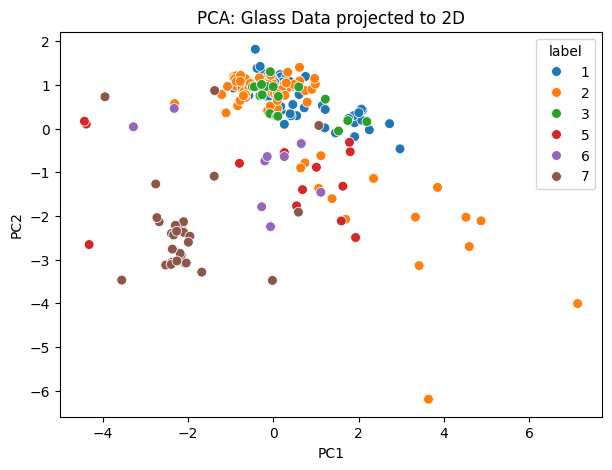

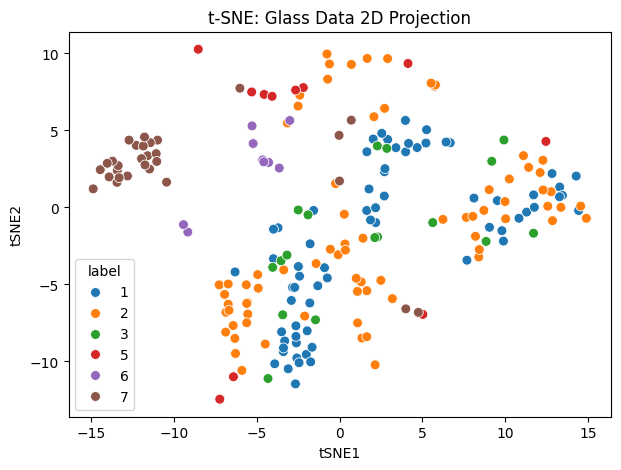

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

url = 'https://drive.google.com/file/d/1QFzghQ5iBStsVt8ktLIAVFBK6RsppeHp/view?usp=sharing'
url_ = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url_)

print("Розмір:", df.shape)
print(df.head())

X = df.drop(columns=['Id', 'Type of glass'])
y = df['Type of glass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Моделі: kNN без PCA та з PCA
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

pipe_pca_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_knn = cross_val_score(pipe_knn, X_train, y_train, cv=cv, scoring='accuracy')
cv_pca_knn = cross_val_score(pipe_pca_knn, X_train, y_train, cv=cv, scoring='accuracy')

print("\nCV accuracy (mean±std)")
print(f"kNN (no PCA):   {cv_knn.mean():.4f} ± {cv_knn.std():.4f}")
print(f"PCA(0.95)+kNN:  {cv_pca_knn.mean():.4f} ± {cv_pca_knn.std():.4f}")

# Порівняння часу навчання
def fit_eval(pipe, label):
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    t1 = time.perf_counter()
    y_pred = pipe.predict(X_test)
    t2 = time.perf_counter()
    print(f"\n{label}")
    if "pca" in pipe.named_steps:
        pca = pipe.named_steps["pca"]
        print(f"  Components: {pca.n_components_} of {X.shape[1]}")
        print(f"  Explained variance sum: {pca.explained_variance_ratio_.sum():.3f}")
    print(f"  Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"  Fit time: {t1 - t0:.4f}s | Predict time: {t2 - t1:.6f}s")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))

fit_eval(pipe_knn, "kNN (no PCA)")
fit_eval(pipe_pca_knn, "PCA(0.95)+kNN")

# Візуалізація PCA (2D)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

pca_df = pd.DataFrame({'PC1': X_pca2[:,0], 'PC2': X_pca2[:,1], 'label': y})
plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', palette='tab10', s=50)
plt.title("PCA: Glass Data projected to 2D")
plt.show()

# Візуалізація t-SNE (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame({'tSNE1': X_tsne[:,0], 'tSNE2': X_tsne[:,1], 'label': y})
plt.figure(figsize=(7,5))
sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='label', palette='tab10', s=50)
plt.title("t-SNE: Glass Data 2D Projection")
plt.show()


#2. Кластерний аналіз
Візьміть будь-яке зображення. За допомогою алгоритму k-means зробіть квантування зображення (зменшення
кількості різних кольорів у зображенні) з глибиною 64, 32, 16 та 8 рівнів для будь-якого обраного самостійно зображення. Порівняйте отримані зображення.
---

Image shape: (600, 800, 3)


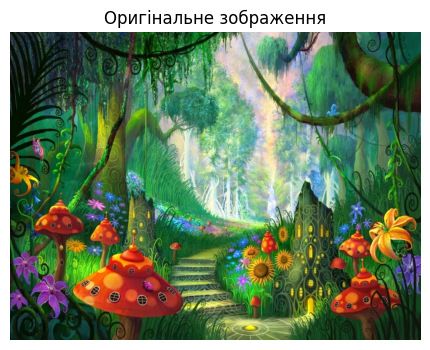


🔹 Обробка для k = 64
Унікальних кольорів: 64

🔹 Обробка для k = 32
Унікальних кольорів: 32

🔹 Обробка для k = 16
Унікальних кольорів: 16

🔹 Обробка для k = 8
Унікальних кольорів: 8


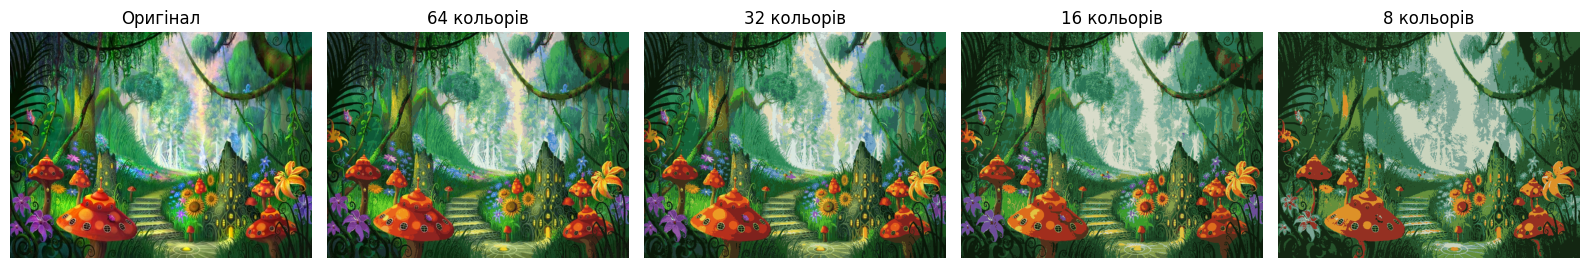

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import requests
from io import BytesIO
from PIL import Image
import matplotlib.image as mpimg

url = 'https://drive.google.com/file/d/1FZvhWvp7vCGpQ9huZbQ_ePzriACUswW7/view?usp=sharing'
url_ = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

# Завантаження через requests
response = requests.get(url_)
img = Image.open(BytesIO(response.content))

# Конвертація у NumPy-масив
img = np.array(img)

H, W, C = img.shape
print("Image shape:", img.shape)

plt.figure(figsize=(6, 4))
plt.title("Оригінальне зображення")
plt.imshow(img)
plt.axis("off")
plt.show()

# Підготовка даних для кластеризації
data = img / 255.0  # нормалізуємо до [0,1]
pixels = data.reshape(-1, 3)

# Кількість кольорів для квантування
k_values = [64, 32, 16, 8]

fig, axes = plt.subplots(1, len(k_values) + 1, figsize=(16, 6))
axes[0].imshow(img)
axes[0].set_title("Оригінал")
axes[0].axis("off")

# Цикл по різних k
for i, k in enumerate(k_values):
    print(f"\n🔹 Обробка для k = {k}")
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pixels)

    # замінюємо кольори пікселів на найближчі центроїди
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    quantized_img = new_colors.reshape(H, W, C)

    axes[i + 1].imshow(quantized_img)
    axes[i + 1].set_title(f"{k} кольорів")
    axes[i + 1].axis("off")

    # показуємо кількість унікальних кольорів
    unique_colors = np.unique((quantized_img * 255).astype(np.uint8).reshape(-1, 3), axis=0)
    print("Унікальних кольорів:", unique_colors.shape[0])

plt.tight_layout()
plt.show()


# 3. Обробка та класифікація текстових даних
Завантажте набір текстових даних (з мітками класів). Проведіть передобробку даних (видаліть стоп-слова, пунктуацію),
за допомогою wordcloud зробіть візуалізацію найбільш поширених слів або n-gram у кожному класі. Векторизуйте тексти
(наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer).
Проведіть класифікацію текстових даних, зробіть оцінку якості.
---

Downloading...
From (original): https://drive.google.com/uc?id=1IwcM9-Dyir1O2JhOxgnRo3Tb9xAt8lWP
From (redirected): https://drive.google.com/uc?id=1IwcM9-Dyir1O2JhOxgnRo3Tb9xAt8lWP&confirm=t&uuid=d94cfb44-b87c-4b44-9498-d3b206b00cf8
To: /content/reviews.txt
100%|██████████| 177M/177M [00:02<00:00, 85.1MB/s]


label
positive    200000
negative    200000
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


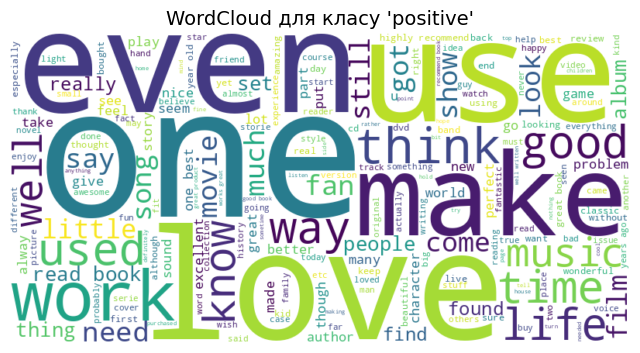

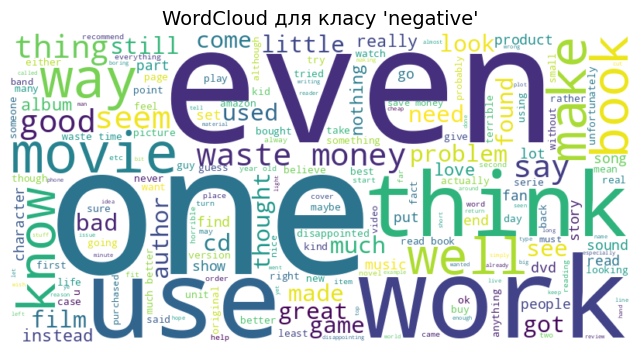

Точність класифікації: 0.8434

Звіт класифікації:
               precision    recall  f1-score   support

    negative       0.85      0.84      0.84     39896
    positive       0.84      0.85      0.84     40104

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



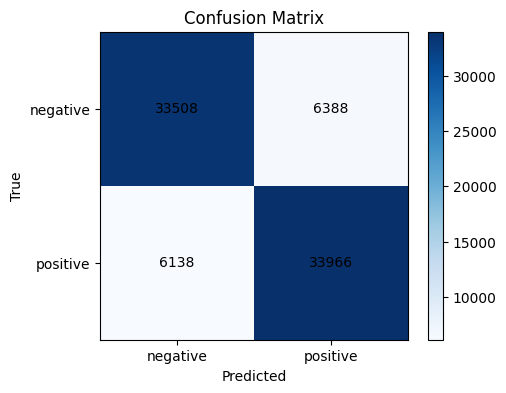

In [3]:
import gdown
import pandas as pd
import re, string, nltk, matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

file_id = "1IwcM9-Dyir1O2JhOxgnRo3Tb9xAt8lWP"
output = "reviews.txt"

# Завантаження файлу
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Зчитування великого текстового файлу пострічково
with open(output, 'r', encoding='utf-8') as f:
    lines = f.read().splitlines()

data = pd.DataFrame(lines, columns=['text'])


# Витягуємо label і текст
data['label'] = data['text'].apply(lambda x: x.split(' ')[0])
data['text'] = data['text'].apply(lambda x: ' '.join(x.split(' ')[1:]))
data['label'] = data['label'].replace({'__label__1': 'negative', '__label__2': 'positive'})

print(data['label'].value_counts())
data.head(3)

# Попередня обробка
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"@\S+", " ", text)
    text = re.sub(r"https*\S+", " ", text)
    text = re.sub(r"#\S+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = ' '.join([w for w in text.split() if w not in stop_words])
    return text.strip()

data['clean_text'] = data['text'].apply(clean_text)

# WordCloud
def visualize(label):
    text = ' '.join(data[data['label'] == label]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud для класу '{label}'", fontsize=14)
    plt.show()

visualize('positive')
visualize('negative')

# TF-IDF + класифікація
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['label'], test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

print("Точність класифікації:", round(accuracy_score(y_test, y_pred), 4))
print("\nЗвіт класифікації:\n", classification_report(y_test, y_pred))

# Матриця помилок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], clf.classes_)
plt.yticks([0,1], clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
plt.show()
